In [1]:
!pip install numpy matplotlib seaborn pillow opencv-python pandas
!pip install rasterio folium 


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/25.4 MB ? eta -:--:--
   -- ------------------------------------- 1.6/25.4 MB 7.6 MB/s eta 0:00:04
   ---- ----------------------------------- 2.9/25.4 MB 7.3 MB/s eta 0:00:04
   ------- -------------------------------- 4.5/25.4 MB 7.2 MB/s eta 0:00:03
   --------- ------------------------------ 6.0/25.4 MB 7.4 MB/s eta 0:00:03
   ----------- ---------------------------- 7.6/25.4 MB 7.3 MB/s eta 0:00:03
   -------------- ------------------------- 9.2/25.4 MB 7.3 MB/s eta 0:00:03
   -------------- ------------------------- 9.4/25.4 MB 7.3 MB/s eta 0:00:03
   -------------- ------------------------- 9.4/25.4 MB 7.3 MB/s eta 0:00:03
   -------------- ------------------------- 9.4/25.4 MB 7.3 MB/s eta 0:00:03
   -------------- ------------------------- 9.4/25.4 MB 7.3 MB/s eta 0:00:03
   -------------- ------------------------- 9.4/25.4 MB 7.3 MB/s eta 0:00:03
   ---------------- ----------------------- 10.5/25.4 MB 4.2 MB/s eta 0:00:04
   --


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
!pip install rasterio tifffile


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from collections import Counter
from pathlib import Path
import glob
import json

In [9]:
# Try to import specialized libraries for satellite imagery
try:
    import rasterio
    HAS_RASTERIO = True
    print("✅ Using rasterio for satellite image analysis")
except ImportError:
    HAS_RASTERIO = False
    print("⚠️  rasterio not available - install with: pip install rasterio")

try:
    from osgeo import gdal
    HAS_GDAL = True
    print("✅ GDAL available for backup image reading")
except ImportError:
    HAS_GDAL = False
    print("⚠️  GDAL not available")

try:
    import tifffile
    HAS_TIFFFILE = True
    print("✅ tifffile available for TIFF reading")
except ImportError:
    HAS_TIFFFILE = False
    print("⚠️  tifffile not available - install with: pip install tifffile")


✅ Using rasterio for satellite image analysis
⚠️  GDAL not available
✅ tifffile available for TIFF reading


In [22]:
def read_satellite_image(file_path):
    """
    Try multiple methods to read satellite imagery TIFF files
    Returns: (image_array, metadata_dict)
    """
    metadata = {}
    
    # Method 1: Try rasterio (best for satellite imagery)
    if HAS_RASTERIO:
        try:
            with rasterio.open(file_path) as src:
                # Read all bands
                image = src.read()  # Shape: (bands, height, width)
                metadata = {
                    'shape': image.shape,
                    'dtype': str(image.dtype),
                    'bands': src.count,
                    'width': src.width,
                    'height': src.height,
                    'crs': str(src.crs) if src.crs else None,
                    'transform': str(src.transform),
                    'nodata': src.nodata,
                    'file_size_mb': os.path.getsize(file_path) / (1024 * 1024)
                }
                return image, metadata
        except Exception as e:
            print(f"   Rasterio failed for {os.path.basename(file_path)}: {e}")
    
    # Method 2: Try tifffile
    if HAS_TIFFFILE:
        try:
            import tifffile
            image = tifffile.imread(file_path)
            metadata = {
                'shape': image.shape,
                'dtype': str(image.dtype),
                'bands': image.shape[0] if len(image.shape) == 3 else 1,
                'file_size_mb': os.path.getsize(file_path) / (1024 * 1024)
            }
            return image, metadata
        except Exception as e:
            print(f"   Tifffile failed for {os.path.basename(file_path)}: {e}")
    
    # Method 3: Try GDAL
    if HAS_GDAL:
        try:
            dataset = gdal.Open(file_path)
            if dataset:
                bands = dataset.RasterCount
                width = dataset.RasterXSize
                height = dataset.RasterYSize
                
                # Read first band for basic info
                band = dataset.GetRasterBand(1)
                array = band.ReadAsArray()
                
                metadata = {
                    'shape': (bands, height, width),
                    'dtype': str(array.dtype),
                    'bands': bands,
                    'width': width,
                    'height': height,
                    'file_size_mb': os.path.getsize(file_path) / (1024 * 1024)
                }
                
                # Try to read all bands
                full_array = np.zeros((bands, height, width), dtype=array.dtype)
                for i in range(bands):
                    band = dataset.GetRasterBand(i + 1)
                    full_array[i] = band.ReadAsArray()
                
                return full_array, metadata
        except Exception as e:
            print(f"   GDAL failed for {os.path.basename(file_path)}: {e}")
    
    # If all methods fail, return basic file info
    metadata = {
        'file_size_mb': os.path.getsize(file_path) / (1024 * 1024),
        'error': 'Could not read image data'
    }
    return None, metadata

In [23]:
def enhanced_roi_analysis(dataset_type="s2"):
    """
    Enhanced analysis for ROI Winter dataset with proper satellite imagery handling
    
    Args:
        dataset_type (str): "s1" for SAR data, "s2" for EO data
    """
    BASE_PATH = r"C:\Users\adars\Downloads\SAR-to-EO"
    
    if dataset_type.lower() == "s1":
        EO_PATH = os.path.join(BASE_PATH, "ROIs2017_winter_s1_extracted", "ROIs2017_winter")
        dataset_name = "SAR (Sentinel-1)"
    else:  # default to s2
        EO_PATH = os.path.join(BASE_PATH, "ROIs2017_winter_s2_extracted", "ROIs2017_winter")
        dataset_name = "EO (Sentinel-2)"
    
    print(f"🌨️  ROI 2017 Winter Dataset - Enhanced Analysis")
    print(f"📡 Dataset Type: {dataset_name}")
    print("=" * 70)
    print(f"📁 Analyzing: {EO_PATH}")
    
    if not os.path.exists(EO_PATH):
        print(f"❌ Path not found: {EO_PATH}")
        return None
    
    # Step 1: Analyze folder structure
    folders = [f for f in os.listdir(EO_PATH) if os.path.isdir(os.path.join(EO_PATH, f))]
    folders.sort()  # Sort for consistent ordering
    
    print(f"\n📊 FOLDER STRUCTURE:")
    print(f"   Total folders: {len(folders)}")
    
    # Step 2: Detailed file analysis
    folder_analysis = {}
    total_files = 0
    successful_reads = 0
    
    print(f"\n🔍 ANALYZING FOLDERS AND FILES...")
    
    for i, folder in enumerate(folders):
        folder_path = os.path.join(EO_PATH, folder)
        tif_files = glob.glob(os.path.join(folder_path, "*.tif")) + glob.glob(os.path.join(folder_path, "*.tiff"))
        
        folder_info = {
            'file_count': len(tif_files),
            'files': [os.path.basename(f) for f in tif_files],
            'sample_metadata': []
        }
        
        total_files += len(tif_files)
        
        # Analyze sample files from this folder
        sample_files = tif_files[:3]  # Analyze first 3 files per folder
        for sample_file in sample_files:
            try:
                image, metadata = read_satellite_image(sample_file)
                if metadata and 'error' not in metadata:
                    successful_reads += 1
                    metadata['filename'] = os.path.basename(sample_file)
                    folder_info['sample_metadata'].append(metadata)
            except Exception as e:
                print(f"   ⚠️  Error with {os.path.basename(sample_file)}: {e}")
        
        folder_analysis[folder] = folder_info
        
        if i < 10:  # Show progress for first 10 folders
            success_count = len(folder_info['sample_metadata'])
            print(f"   📂 {folder}: {len(tif_files)} files, {success_count} successfully analyzed")
    
    print(f"\n📈 ANALYSIS SUMMARY:")
    print(f"   Total folders: {len(folders)}")
    print(f"   Total TIF files: {total_files}")
    print(f"   Successfully read: {successful_reads}")
    print(f"   Success rate: {successful_reads/min(total_files, len(folders)*3)*100:.1f}%")
    print(f"   Average files per folder: {total_files/len(folders):.1f}")
    
    # Step 3: Analyze image properties
    analyze_image_properties(folder_analysis)
    
    # Step 4: Create visualizations
    create_enhanced_visualizations(folder_analysis, EO_PATH)
    
    return folder_analysis


In [24]:
def analyze_image_properties(folder_analysis):
    """Analyze properties of successfully read images"""
    print(f"\n🖼️  IMAGE PROPERTIES ANALYSIS:")
    
    all_metadata = []
    for folder, info in folder_analysis.items():
        all_metadata.extend(info['sample_metadata'])
    
    if not all_metadata:
        print("   No images successfully analyzed")
        return
    
    # Analyze dimensions
    shapes = [meta['shape'] for meta in all_metadata if 'shape' in meta]
    bands = [meta['bands'] for meta in all_metadata if 'bands' in meta]
    dtypes = [meta['dtype'] for meta in all_metadata if 'dtype' in meta]
    file_sizes = [meta['file_size_mb'] for meta in all_metadata if 'file_size_mb' in meta]
    
    if shapes:
        unique_shapes = list(set([tuple(s) for s in shapes]))
        print(f"   📐 Image shapes found: {unique_shapes}")
    
    if bands:
        unique_bands = list(set(bands))
        print(f"   🌈 Band counts: {unique_bands}")
        print(f"   📊 Band count distribution: {dict(Counter(bands))}")
    
    if dtypes:
        unique_dtypes = list(set(dtypes))
        print(f"   💾 Data types: {unique_dtypes}")
    
    if file_sizes:
        print(f"   📦 File sizes: {np.mean(file_sizes):.2f} MB (avg)")
        print(f"       Range: {np.min(file_sizes):.2f} - {np.max(file_sizes):.2f} MB")
    
    print(f"   ✅ Successfully analyzed: {len(all_metadata)} sample images")


In [25]:
def create_enhanced_visualizations(folder_analysis, base_path):
    """Create enhanced visualizations for the dataset"""
    print(f"\n📊 CREATING VISUALIZATIONS...")
    
    # Extract data for plotting
    folder_names = list(folder_analysis.keys())
    file_counts = [info['file_count'] for info in folder_analysis.values()]
    success_counts = [len(info['sample_metadata']) for info in folder_analysis.values()]
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 12))
    
    # Plot 1: Files per folder (bar chart)
    plt.subplot(2, 3, 1)
    x_pos = range(len(folder_names[:20]))  # Show first 20 folders
    plt.bar(x_pos, file_counts[:20], alpha=0.7, color='skyblue', label='Total Files')
    plt.bar(x_pos, [min(3, fc) for fc in file_counts[:20]], alpha=0.9, color='darkblue', label='Analyzed')
    plt.title('Files per Folder (First 20 folders)')
    plt.xlabel('Folder Index')
    plt.ylabel('File Count')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: File count distribution
    plt.subplot(2, 3, 2)
    plt.hist(file_counts, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
    plt.axvline(np.mean(file_counts), color='red', linestyle='--', linewidth=2, 
                label=f'Average: {np.mean(file_counts):.1f}')
    plt.title('Distribution of Files per Folder')
    plt.xlabel('Number of Files')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Analysis success rate
    plt.subplot(2, 3, 3)
    success_rates = [sc/min(3, fc) if fc > 0 else 0 for sc, fc in zip(success_counts, file_counts)]
    plt.hist(success_rates, bins=10, alpha=0.7, color='orange', edgecolor='black')
    plt.title('Analysis Success Rate Distribution')
    plt.xlabel('Success Rate')
    plt.ylabel('Number of Folders')
    plt.grid(True, alpha=0.3)
    
    # Plot 4: File size analysis (if available)
    plt.subplot(2, 3, 4)
    all_sizes = []
    for info in folder_analysis.values():
        for meta in info['sample_metadata']:
            if 'file_size_mb' in meta:
                all_sizes.append(meta['file_size_mb'])
    
    if all_sizes:
        plt.hist(all_sizes, bins=15, alpha=0.7, color='purple', edgecolor='black')
        plt.axvline(np.mean(all_sizes), color='red', linestyle='--', linewidth=2,
                    label=f'Average: {np.mean(all_sizes):.1f} MB')
        plt.title('File Size Distribution')
        plt.xlabel('File Size (MB)')
        plt.ylabel('Frequency')
        plt.legend()
    else:
        plt.text(0.5, 0.5, 'No file size data available', ha='center', va='center', 
                transform=plt.gca().transAxes)
        plt.title('File Size Distribution')
    plt.grid(True, alpha=0.3)
    
    # Plot 5: Band count analysis
    plt.subplot(2, 3, 5)
    all_bands = []
    for info in folder_analysis.values():
        for meta in info['sample_metadata']:
            if 'bands' in meta:
                all_bands.append(meta['bands'])
    
    if all_bands:
        band_counts = Counter(all_bands)
        plt.bar(band_counts.keys(), band_counts.values(), alpha=0.7, color='coral')
        plt.title('Band Count Distribution')
        plt.xlabel('Number of Bands')
        plt.ylabel('Frequency')
    else:
        plt.text(0.5, 0.5, 'No band count data available', ha='center', va='center',
                transform=plt.gca().transAxes)
        plt.title('Band Count Distribution')
    plt.grid(True, alpha=0.3)
    
    # Plot 6: Summary statistics
    plt.subplot(2, 3, 6)
    plt.axis('off')
    
    # Create summary text
    total_folders = len(folder_names)
    total_files = sum(file_counts)
    total_analyzed = sum(success_counts)
    avg_file_size = np.mean(all_sizes) if all_sizes else 0
    most_common_bands = Counter(all_bands).most_common(1)[0] if all_bands else (0, 0)
    
    summary_text = f"""
    📊 DATASET SUMMARY
    
    📁 Total Folders: {total_folders}
    📄 Total Files: {total_files}
    ✅ Successfully Analyzed: {total_analyzed}
    
    📈 Average Files/Folder: {np.mean(file_counts):.1f}
    📦 Average File Size: {avg_file_size:.1f} MB
    🌈 Most Common Bands: {most_common_bands[0]}
    
    📍 Expected ROI Files: {46 * 557}
    ✓ Match Expected: {'YES' if abs(total_files - 46*557) < 100 else 'NO'}
    """
    
    plt.text(0.1, 0.9, summary_text, transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))
    
    plt.suptitle('ROI 2017 Winter Dataset - Comprehensive Analysis', fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()

In [26]:
def visualize_sample_satellite_images(folder_analysis, base_path, n_samples=6):
    """Visualize sample satellite images with proper band handling"""
    print(f"\n🖼️  VISUALIZING SAMPLE SATELLITE IMAGES...")
    
    # Collect sample files with successful metadata
    sample_data = []
    for folder, info in folder_analysis.items():
        if info['sample_metadata']:
            folder_path = os.path.join(base_path, folder)
            for meta in info['sample_metadata'][:1]:  # One per folder
                file_path = os.path.join(folder_path, meta['filename'])
                sample_data.append((file_path, folder, meta))
                if len(sample_data) >= n_samples:
                    break
        if len(sample_data) >= n_samples:
            break
    
    if not sample_data:
        print("   No successfully analyzed images to visualize")
        return
    
    # Create visualization
    n_cols = 3
    n_rows = (len(sample_data) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    fig.suptitle('Sample Satellite Images from ROI 2017 Winter Dataset', fontsize=16)
    
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.flatten()
    
    for i, (file_path, folder, metadata) in enumerate(sample_data):
        try:
            # Read the image
            image, _ = read_satellite_image(file_path)
            
            if image is not None:
                # Handle different image formats
                if len(image.shape) == 3:  # Multi-band image (bands, height, width)
                    if image.shape[0] >= 3:
                        # Create RGB composite (assuming bands 1,2,3 are RGB or similar)
                        rgb_image = np.transpose(image[:3], (1, 2, 0))
                        # Normalize for display
                        rgb_image = normalize_for_display(rgb_image)
                        axes[i].imshow(rgb_image)
                    else:
                        # Single band or fewer than 3 bands
                        single_band = image[0] if image.shape[0] > 0 else image
                        axes[i].imshow(single_band, cmap='viridis')
                else:
                    # 2D image
                    axes[i].imshow(image, cmap='viridis')
                
                # Set title with metadata
                title = f"{folder}\n{metadata['filename']}\n"
                title += f"Shape: {metadata.get('shape', 'N/A')}\n"
                title += f"Bands: {metadata.get('bands', 'N/A')}"
                axes[i].set_title(title, fontsize=10)
                axes[i].axis('off')
            else:
                axes[i].text(0.5, 0.5, f'Could not load\n{folder}\n{metadata["filename"]}', 
                            ha='center', va='center', transform=axes[i].transAxes)
                axes[i].axis('off')
                
        except Exception as e:
            axes[i].text(0.5, 0.5, f'Error loading\n{folder}\n{str(e)[:50]}...', 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(len(sample_data), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [27]:
def normalize_for_display(image):
    """Normalize image for display"""
    # Handle different data types
    if image.dtype in [np.uint16, np.int16]:
        # For 16-bit images, normalize to 0-255
        image = image.astype(np.float32)
        image = ((image - image.min()) / (image.max() - image.min()) * 255).astype(np.uint8)
    elif image.dtype == np.float32 or image.dtype == np.float64:
        # For float images, clip to 0-1 range
        image = np.clip(image, 0, 1)
    
    return image


🚀 Starting Enhanced ROI 2017 Winter Dataset Analysis...

📡 Which dataset would you like to analyze?
1. S1 (SAR - Sentinel-1): C:\Users\adars\Downloads\SAR-to-EO\ROIs2017_winter_s1_extracted\ROIs2017_winter
2. S2 (EO - Sentinel-2):  C:\Users\adars\Downloads\SAR-to-EO\ROIs2017_winter_s2_extracted\ROIs2017_winter
3. Both datasets



Enter your choice (1, 2, or 3):  3



📊 ANALYZING SAR DATASET...
🌨️  ROI 2017 Winter Dataset - Enhanced Analysis
📡 Dataset Type: SAR (Sentinel-1)
📁 Analyzing: C:\Users\adars\Downloads\SAR-to-EO\ROIs2017_winter_s1_extracted\ROIs2017_winter

📊 FOLDER STRUCTURE:
   Total folders: 46

🔍 ANALYZING FOLDERS AND FILES...
   📂 s1_102: 752 files, 3 successfully analyzed
   📂 s1_103: 763 files, 3 successfully analyzed
   📂 s1_104: 508 files, 3 successfully analyzed
   📂 s1_107: 775 files, 3 successfully analyzed
   📂 s1_108: 783 files, 3 successfully analyzed
   📂 s1_109: 553 files, 3 successfully analyzed
   📂 s1_112: 839 files, 3 successfully analyzed
   📂 s1_115: 729 files, 3 successfully analyzed
   📂 s1_116: 777 files, 3 successfully analyzed
   📂 s1_117: 784 files, 3 successfully analyzed

📈 ANALYSIS SUMMARY:
   Total folders: 46
   Total TIF files: 31825
   Successfully read: 138
   Success rate: 100.0%
   Average files per folder: 691.8

🖼️  IMAGE PROPERTIES ANALYSIS:
   📐 Image shapes found: [(2, 256, 256)]
   🌈 Band counts

C:\Users\adars\AppData\Local\Temp\ipykernel_13704\3426321398.py:117: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\adars\AppData\Local\Temp\ipykernel_13704\3426321398.py:117: UserWarning: Glyph 128193 (\N{FILE FOLDER}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\adars\AppData\Local\Temp\ipykernel_13704\3426321398.py:117: UserWarning: Glyph 128196 (\N{PAGE FACING UP}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\adars\AppData\Local\Temp\ipykernel_13704\3426321398.py:117: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\adars\AppData\Local\Temp\ipykernel_13704\3426321398.py:117: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\adars\AppData\Local\Temp\ipykernel_13704\3426321398.py:117: UserWarning: Glyph 128230 (\N{PACKAGE}) mis

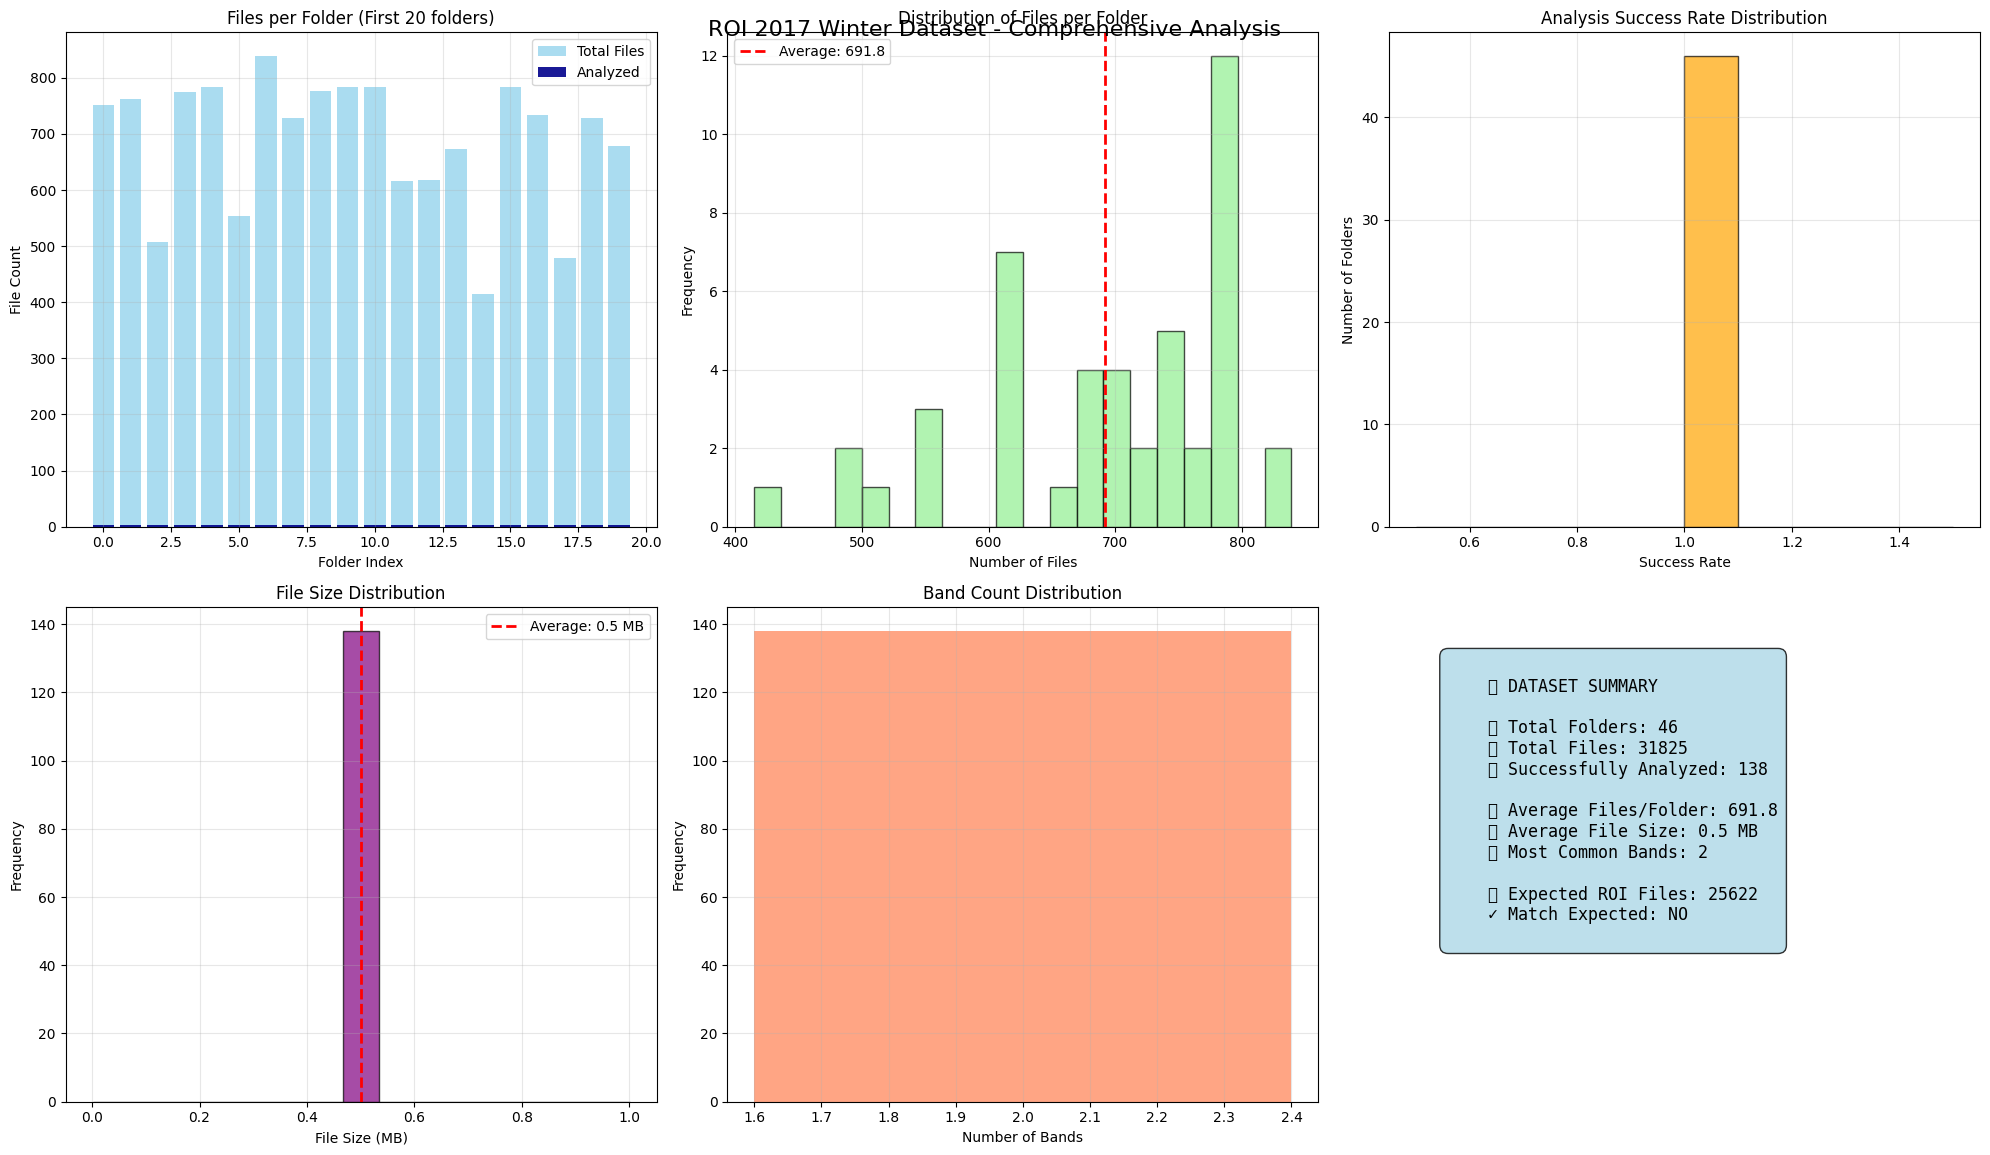


🖼️  VISUALIZING SAMPLE SATELLITE IMAGES...


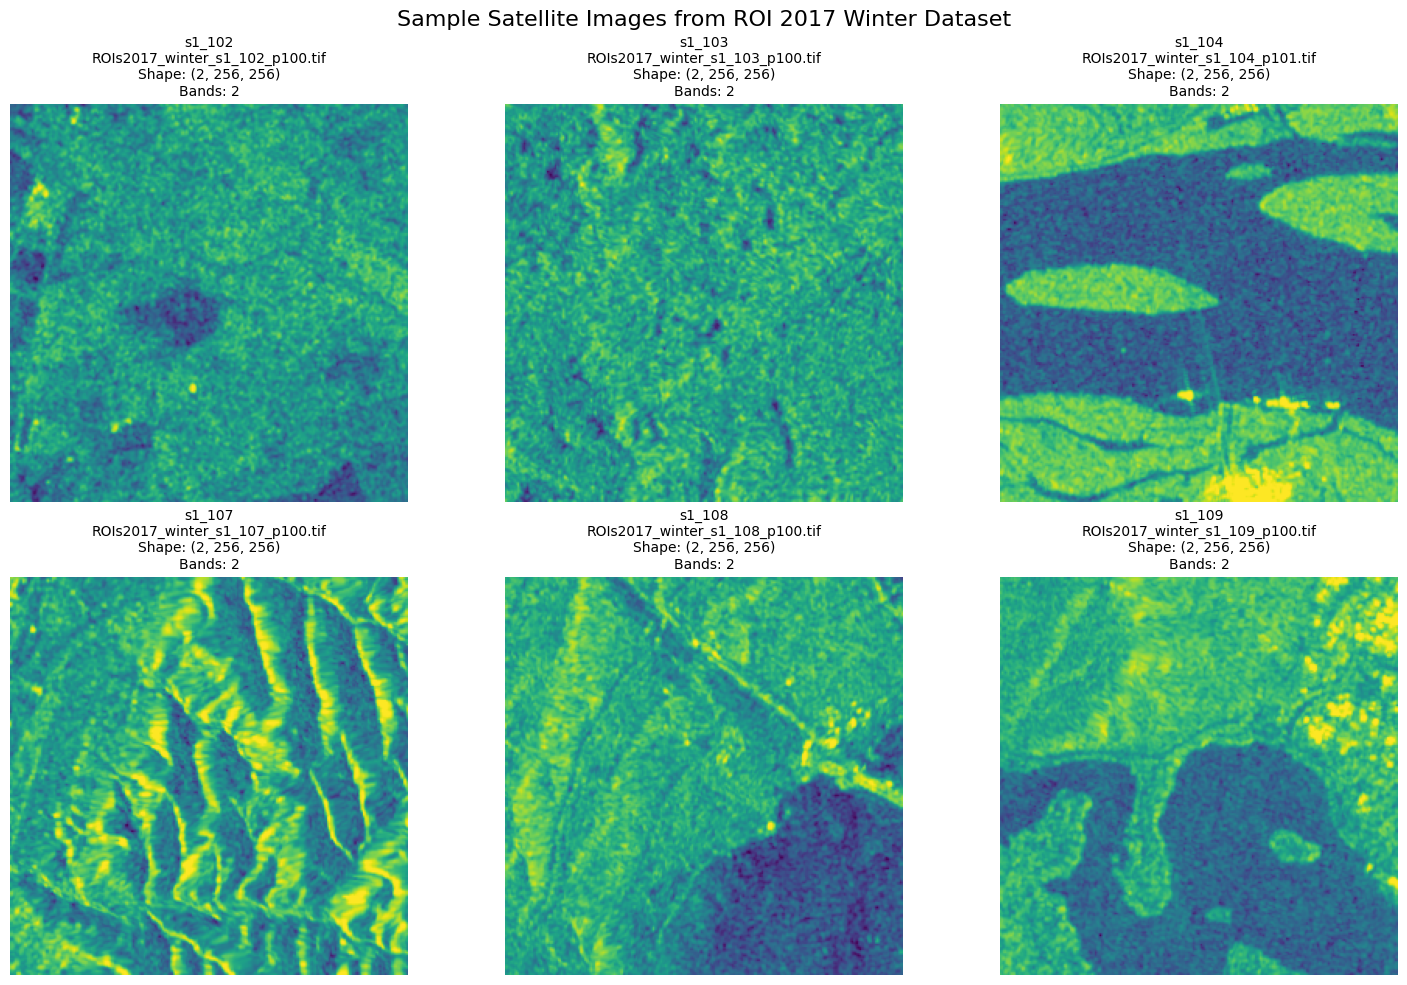


✅ SAR ANALYSIS COMPLETE!

📊 ANALYZING EO DATASET...
🌨️  ROI 2017 Winter Dataset - Enhanced Analysis
📡 Dataset Type: EO (Sentinel-2)
📁 Analyzing: C:\Users\adars\Downloads\SAR-to-EO\ROIs2017_winter_s2_extracted\ROIs2017_winter

📊 FOLDER STRUCTURE:
   Total folders: 46

🔍 ANALYZING FOLDERS AND FILES...
   📂 s2_102: 752 files, 3 successfully analyzed
   📂 s2_103: 763 files, 3 successfully analyzed
   📂 s2_104: 508 files, 3 successfully analyzed
   📂 s2_107: 775 files, 3 successfully analyzed
   📂 s2_108: 783 files, 3 successfully analyzed
   📂 s2_109: 553 files, 3 successfully analyzed
   📂 s2_112: 839 files, 3 successfully analyzed
   📂 s2_115: 729 files, 3 successfully analyzed
   📂 s2_116: 777 files, 3 successfully analyzed
   📂 s2_117: 784 files, 3 successfully analyzed

📈 ANALYSIS SUMMARY:
   Total folders: 46
   Total TIF files: 31825
   Successfully read: 138
   Success rate: 100.0%
   Average files per folder: 691.8

🖼️  IMAGE PROPERTIES ANALYSIS:
   📐 Image shapes found: [(13, 25

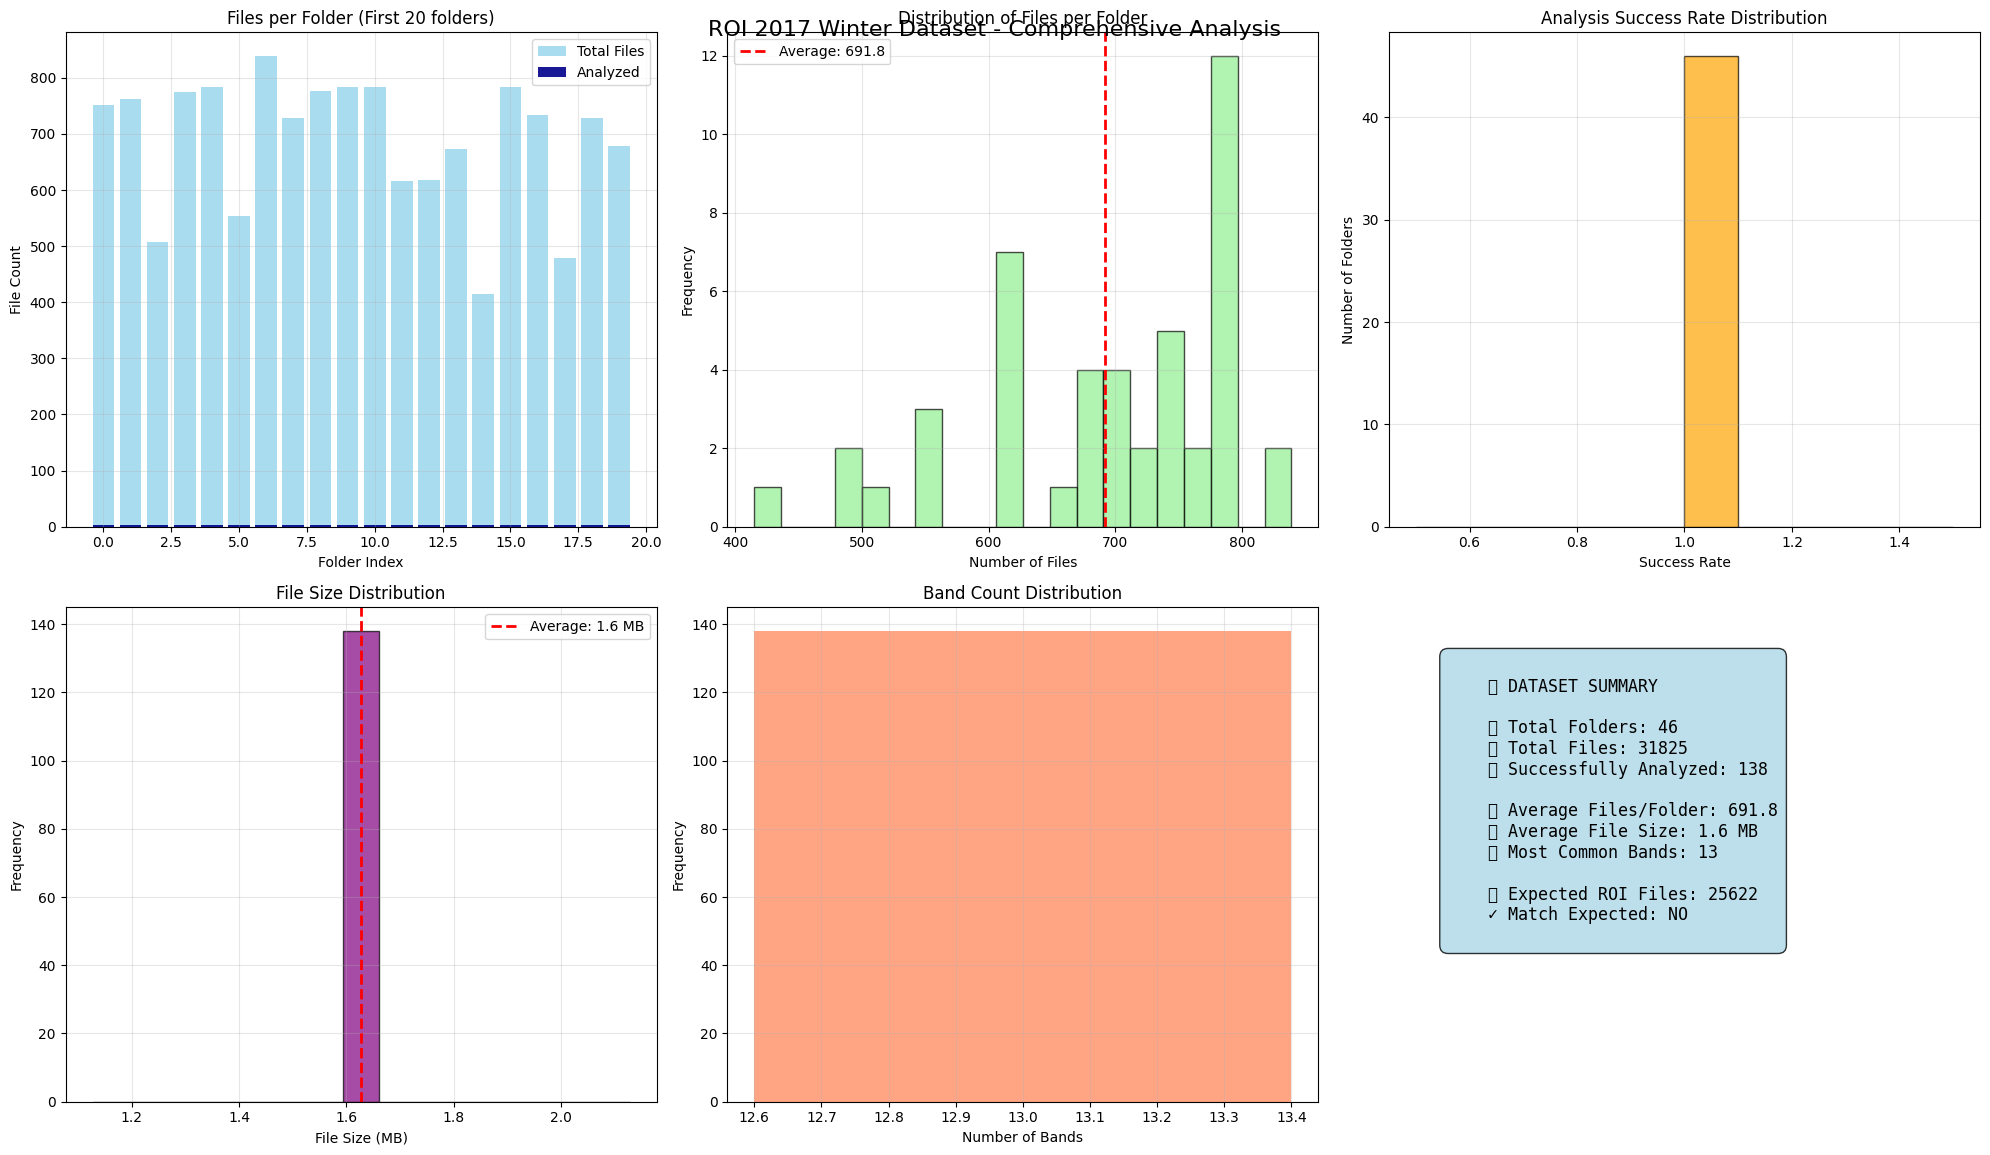


🖼️  VISUALIZING SAMPLE SATELLITE IMAGES...


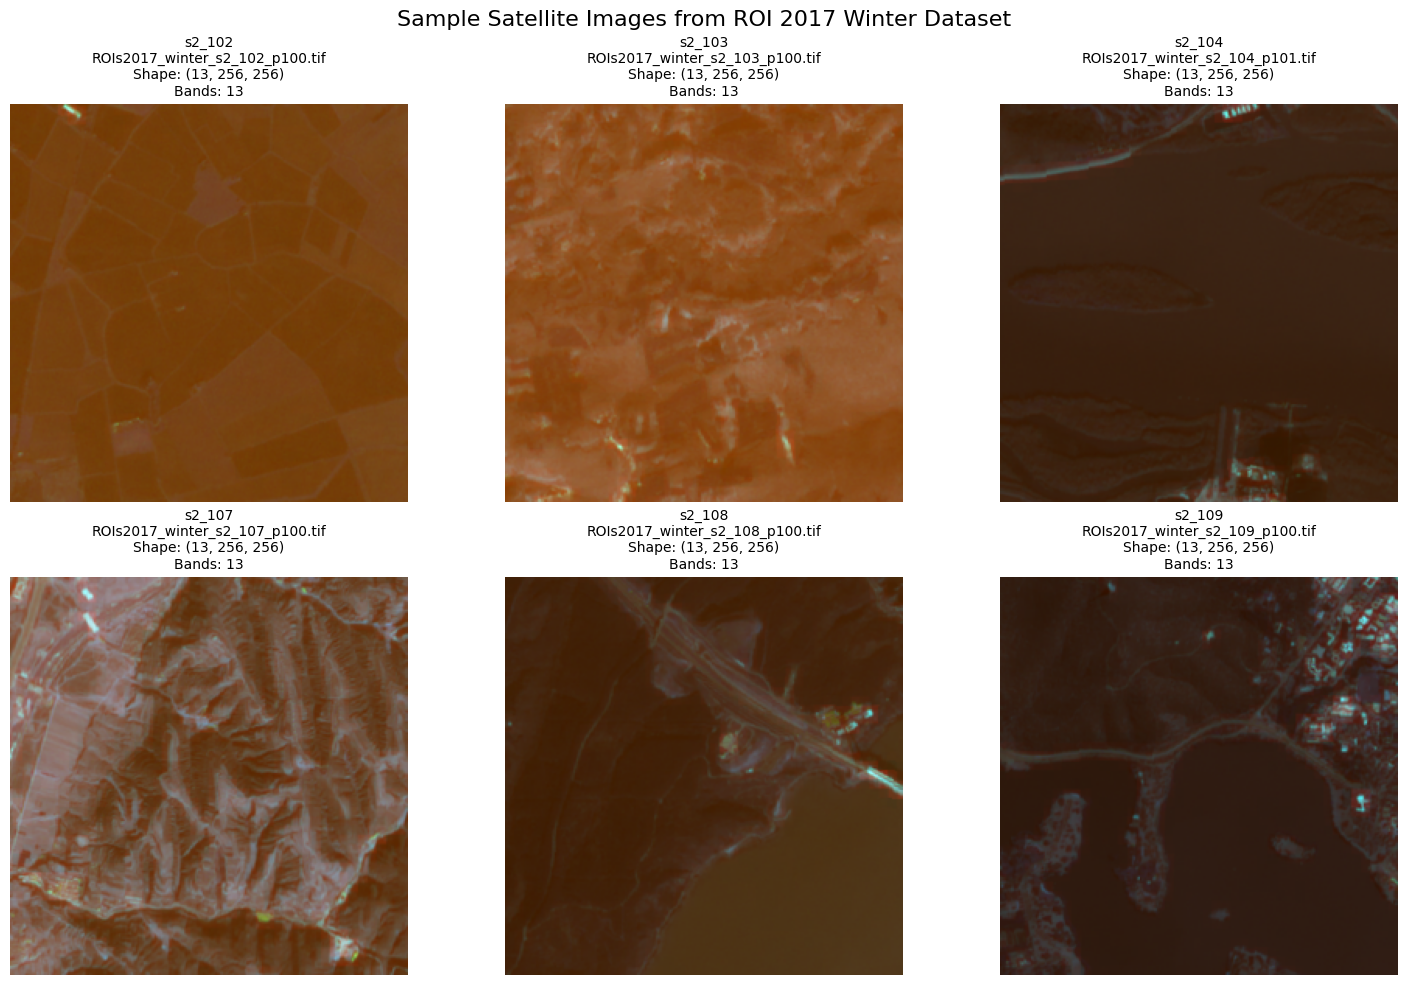


✅ EO ANALYSIS COMPLETE!
💾 S1 results saved to: roi_winter_s1_enhanced_analysis.json
💾 S2 results saved to: roi_winter_s2_enhanced_analysis.json


In [30]:
def main():
    """Main function to run enhanced analysis"""
    print("🚀 Starting Enhanced ROI 2017 Winter Dataset Analysis...")
    print("=" * 70)
    
    # Check for required libraries
    if not (HAS_RASTERIO or HAS_TIFFFILE or HAS_GDAL):
        print("❌ No suitable library found for reading satellite imagery!")
        print("📦 Please install one of:")
        print("   • pip install rasterio")
        print("   • pip install tifffile") 
        print("   • conda install gdal")
        return
    
    # Ask user which dataset to analyze
    print("\n📡 Which dataset would you like to analyze?")
    print("1. S1 (SAR - Sentinel-1): C:\\Users\\adars\\Downloads\\SAR-to-EO\\ROIs2017_winter_s1_extracted\\ROIs2017_winter")
    print("2. S2 (EO - Sentinel-2):  C:\\Users\\adars\\Downloads\\SAR-to-EO\\ROIs2017_winter_s2_extracted\\ROIs2017_winter")
    print("3. Both datasets")
    
    choice = input("\nEnter your choice (1, 2, or 3): ").strip()
    
    if choice == "1":
        datasets = [("s1", "SAR")]
    elif choice == "2":
        datasets = [("s2", "EO")]
    elif choice == "3":
        datasets = [("s1", "SAR"), ("s2", "EO")]
    else:
        print("Invalid choice, analyzing S2 (EO) dataset by default...")
        datasets = [("s2", "EO")]
    
    all_results = {}
    
    for dataset_type, dataset_name in datasets:
        print(f"\n{'='*70}")
        print(f"📊 ANALYZING {dataset_name} DATASET...")
        print(f"{'='*70}")
        
        # Run enhanced analysis
        results = enhanced_roi_analysis(dataset_type)
        
        if results:
            all_results[dataset_type] = results
            
            # Visualize sample images
            BASE_PATH = r"C:\Users\adars\Downloads\SAR-to-EO"
            if dataset_type == "s1":
                DATA_PATH = os.path.join(BASE_PATH, "ROIs2017_winter_s1_extracted", "ROIs2017_winter")
            else:
                DATA_PATH = os.path.join(BASE_PATH, "ROIs2017_winter_s2_extracted", "ROIs2017_winter")
            
            visualize_sample_satellite_images(results, DATA_PATH)
            
            print(f"\n✅ {dataset_name} ANALYSIS COMPLETE!")
        else:
            print(f"❌ Failed to analyze {dataset_name} dataset")
    
    if all_results:
        # Save results
        try:
            for dataset_type, results in all_results.items():
                # Convert numpy types to Python types for JSON serialization
                json_results = {}
                for folder, info in results.items():
                    json_info = {
                        'file_count': info['file_count'],
                        'files': info['files'],
                        'sample_metadata': []
                    }
                    for meta in info['sample_metadata']:
                        json_meta = {}
                        for key, value in meta.items():
                            if isinstance(value, np.ndarray):
                                json_meta[key] = value.tolist()
                            elif isinstance(value, (np.integer, np.floating)):
                                json_meta[key] = value.item()
                            else:
                                json_meta[key] = value
                        json_info['sample_metadata'].append(json_meta)
                    json_results[folder] = json_info
                
                filename = f'roi_winter_{dataset_type}_enhanced_analysis.json'
                with open(filename, 'w') as f:
                    json.dump(json_results, f, indent=2)
                print(f"💾 {dataset_type.upper()} results saved to: {filename}")
                
        except Exception as e:
            print(f"⚠️  Could not save results: {e}")
            import traceback
            traceback.print_exc()

if __name__ == "__main__":
    main()